In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import shutil
import numpy as np
import random

from ultralytics import YOLO
from PIL import Image

# EDA

In [2]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

In [3]:
metadata.head()

,FileName,Species,ScientificName,Magnification,Witdh,Heigth,Resolution
0,STMHD0001,Nuttall oak,Quercus texana Buckley,100,1024,768,118
1,STMHD0002,Nuttall oak,Quercus texana Buckley,100,1024,768,118
2,STMHD0003,Nuttall oak,Quercus texana Buckley,100,1024,768,118
3,STMHD0004,Nuttall oak,Quercus texana Buckley,100,1024,768,118
4,STMHD0005,Nuttall oak,Quercus texana Buckley,100,1024,768,118


In [4]:
metadata.Species.unique()

array(['Nuttall oak', 'Shumard oak', 'American elm', 'American Holly', 'Cherrybark oak', 'Shagbark hickory', 'Swamp chestnut oak', 'Water oak', 'Willow oak', 'Winged elm', 'Ash', 'Deerberry', 'Leatherwood', 'Red maple', 'Post oak', 'Black gum', 'Willow', 'Poplar'], dtype=object)

In [ ]:
# Calcular el número total de imágenes
total_images = len(metadata)

# Calcular la media y desviación estándar de Width y Height
mean_width = metadata['Witdh'].mean()
std_width = metadata['Witdh'].std()
mean_height = metadata['Heigth'].mean()
std_height = metadata['Heigth'].std()

# Número de especies únicas
unique_species = metadata['Species'].nunique()

# Frecuencia de cada especie
species_frequency = metadata['Species'].value_counts()

# Frecuencia de resoluciones (Width x Height)
resolution_frequency = metadata.groupby(['Witdh', 'Heigth']).size()

# Media de la magnificación
mean_magnification = metadata['Magnification'].mean()

# Frecuencia de magnificación
magnification_frequency = metadata['Magnification'].value_counts()

# Print results
print("Total de imágenes:", total_images)
print("Witdh promedio:", mean_width, "Desviación estándar del ancho:", std_width)
print("Heigth promedio:", mean_height, "Desviación estándar de la altura:", std_height)
print("Número de especies únicas:", unique_species)
print("Frecuencia de cada especie:", species_frequency)
print("Frecuencia de resoluciones:", resolution_frequency)
print("Magnificación promedio:", mean_magnification)
print("Frecuencia de magnificaciones:", magnification_frequency)


Total de imágenes: 10715
Witdh promedio: 1407.319085394307 Desviación estándar del ancho: 495.5886844096622
Heigth promedio: 1055.4893140457302 Desviación estándar de la altura: 371.6915133072467
Número de especies únicas: 18
Frecuencia de cada especie: Species
Poplar                3068
Nuttall oak           2975
Shumard oak           1612
Water oak              653
Willow oak             568
Cherrybark oak         286
Winged elm             205
Ash                    200
Post oak               196
American elm           185
Leatherwood            130
Swamp chestnut oak     129
American Holly         100
Red maple              100
Shagbark hickory        91
Deerberry               85
Willow                  82
Black gum               50
Name: count, dtype: int64
Frecuencia de resoluciones: Witdh  Heigth
1024   768       6704
2048   1536      4011
dtype: int64
Magnificación promedio: 270.32197853476436
Frecuencia de magnificaciones: Magnification
200    5740
400    4170
100     805
Nam

In [6]:
path = 'datasets/train/labels'

line_counts = []

for filename in os.listdir(path):
    if filename.endswith('.txt'): 
        with open(os.path.join(path, filename), 'r') as file:
            lines = file.readlines()
            line_counts.append(len(lines)) 

if line_counts:
    mean_boxes = np.mean(line_counts)
    variance = np.var(line_counts)
    std_dev = variance ** 0.5
    print(f'Total de bounding boxes: {sum(line_counts)}')
    print(f'Media de bounding boxes por imagen: {mean_boxes}')
    print(f'Desviación estándar de bounding boxes por imagen: {std_dev}')
else:
    print("No se encontraron archivos .txt en el directorio.")

Total de bounding boxes: 846556
Media de bounding boxes por imagen: 79.00662622491834
Desviación estándar de bounding boxes por imagen: 68.37540588312125


# Preprocesamiento

In [7]:
#Mediciones 1 plant-out
def onePlantOut(plant_name):
  main_folder = 'datasets'

  train_images_folder = os.path.join(main_folder, 'train/images')
  train_labels_folder = os.path.join(main_folder, 'train/labels')
  val_images_folder = os.path.join(main_folder, 'val/images')
  val_labels_folder = os.path.join(main_folder, 'val/labels')

  folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
  for folder in folders:
      if not os.path.exists(folder):
          os.makedirs(folder)

  # Seleccionar la planta a medir su rendimiento
  plant = plant_name
  trainFiles = metadata[metadata['Species'] != plant]['FileName'].tolist()
  valFiles = metadata[metadata['Species'] == plant]['FileName'].tolist()

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in trainFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in valFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))



In [8]:
holdOut(random_seed = 42, test_size = 0.2)
# onePlantOut("Nuttall oak")

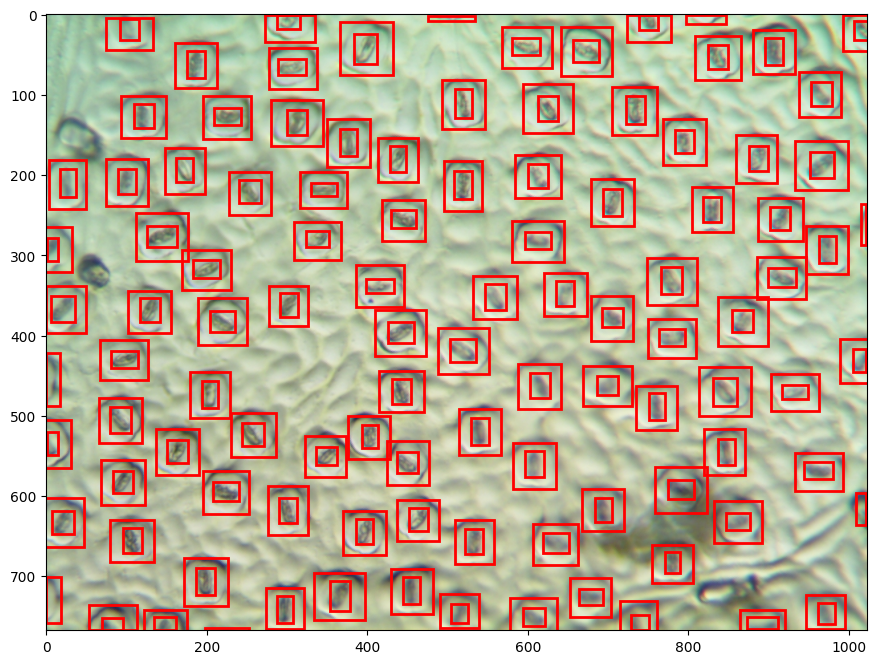

In [9]:
PATH_images = "datasets/train/images"
PATH_labels = "datasets/train/labels"
plant_type = '/STMHD'
number = "0005"
image_path = f"{PATH_images}{plant_type}{number}.jpg"
txt_path = f"{PATH_labels}{plant_type}{number}.txt"

def show_image(image_path, txt_path):
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Leer y mostrar el contenido del archivo .txt
    with open(txt_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        w = width * img.shape[1]
        h = height * img.shape[0]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
show_image(image_path, txt_path)

# YOLO

Para el entrenamiento primero se debe elegir un modelo base para partir. Para ello se tienen los modelos `yolov8n.pt` y `yolov10n.pt` en sus respectivas carpetas. Se puede experimentar con modelos más grandes, pero los resultados que obtuvimos no eran muy diferentes y hacian inviable el entramiento de tantos parámetros. Junto a que posiblemente no se tenga siempre un buen pc, se eligieron estos modelos nano.

Presentamos una forma de entrenar un modelo de `yolov10n.pt` en este notebook, tanto con el ajuste automático (simple), como el ajustado manualmente.

## Entrenamiento Simple

In [ ]:
modelSimple = YOLO('Modelos\yolov10\yolov10n.pt')

# Entrenar el modelo
modelSimple.train(data='YOLO8INFO.yaml', epochs=30, imgsz=640, batch=16, device=0) #Simple
modelSimple.save('Modelos\yolov10\HoldOutSimpleYolov10n.pt')

## Entrenamiento ajustado

In [14]:
modelAdjust = YOLO('Modelos\yolov10\yolov10n.pt')
# Entrenar el modelo con hiperparámetros ajustados
modelAdjust.train(
    data='YOLO8INFO.yaml',     # Archivo de configuración de los datos
    epochs=100,                 # Aumentar el número de épocas para una mayor convergencia
    patience = 20,             # Number of epochs to wait without improvement in validation metrics 
    imgsz=640,                 # Tamaño de las imágenes para mejorar la precisión
    batch=16,                  # Tamaño del lote mayor para un entrenamiento más rápido (ajustar según la GPU)
    device=0,                  # Especificar el dispositivo GPU
    lr0=0.01,                  # Tasa de aprendizaje inicial más alta
    lrf=0.2,                   # Factor de reducción de la tasa de aprendizaje
    momentum=0.937,            # Momento optimizado para estabilizar el entrenamiento
    weight_decay=0.0005,       # Decaimiento del peso para evitar el sobreajuste
    warmup_epochs=5.0,         # Épocas de calentamiento para estabilizar el modelo al inicio
    warmup_momentum=0.8,       # Momento de calentamiento
    warmup_bias_lr=0.1,        # Tasa de aprendizaje inicial para el sesgo
    box= 7,                    # Ponderación de la pérdida de la caja
    cls=0.5,                   # Ponderación de la pérdida de clasificación
    dfl=1.0,                   # Ponderación de la pérdida de distribución de la etiqueta
    hsv_h=0.015,               # Augmentación de color - ajuste de tono
    hsv_s=0.7,                 # Augmentación de color - ajuste de saturación
    hsv_v=0.4,                 # Augmentación de color - ajuste de valor
    degrees= 60,               # Augmentación - rotación de la imagen
    translate=0.1,             # Augmentación - traducción de la imagen
    scale=0.5,                 # Augmentación - escalado de la imagen
    shear=0.0,                 # Augmentación - cizallamiento
    flipud=0.0,                # Volteo vertical (no comúnmente usado)
    fliplr=0.5,                # Volteo horizontal (común para imágenes de objetos)
    mosaic=0.2,                # Habilitar la mezcla de mosaico (aumenta el conjunto de datos)
    mixup=0.4,                 # Habilitar mixup para mezclar las imágenes
    label_smoothing=0.1,       # Suavización de etiquetas para evitar sobreajuste
    dropout = 0.1,             # Tasa de droput para regularizar
)
modelAdjust.save('Modelos\yolov10\HoldOutAdjustYolov10n.pt')

New https://pypi.org/project/ultralytics/8.3.31 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov10\HoldOutSimpleYolov10n.pt, data=YOLO8INFO.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

train: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 8572 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8572/8572 [00:10<00:00, 844.44it/s] 


train: New cache created: C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.67G      2.813      1.535      1.521       1664        640: 100%|██████████| 536/536 [03:56<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.61it/s]


                   all       2143     163185      0.935      0.922      0.962      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.4G      2.234        1.2      1.311       1595        640: 100%|██████████| 536/536 [03:19<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:28<00:00,  2.38it/s]


                   all       2143     163185      0.934      0.923      0.969      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.2G      2.151      1.165      1.291       1549        640: 100%|██████████| 536/536 [04:01<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.09it/s]


                   all       2143     163185      0.944      0.933      0.977      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.53G       2.12      1.151      1.284       1374        640: 100%|██████████| 536/536 [03:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.11it/s]


                   all       2143     163185      0.946      0.926      0.977      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100        11G      2.091      1.133      1.277       1367        640: 100%|██████████| 536/536 [03:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:23<00:00,  2.86it/s]


                   all       2143     163185      0.942      0.928      0.974      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      2.069      1.125       1.27       1265        640: 100%|██████████| 536/536 [09:36<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [02:09<00:00,  1.94s/it]


                   all       2143     163185      0.944      0.941       0.98      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.9G      2.016      1.097       1.26       1185        640: 100%|██████████| 536/536 [03:30<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]


                   all       2143     163185      0.942      0.942       0.98      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.7G      1.992      1.083      1.256       1565        640: 100%|██████████| 536/536 [02:52<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  2.99it/s]


                   all       2143     163185      0.949      0.937      0.981      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.91G      1.955      1.062      1.247       1221        640: 100%|██████████| 536/536 [02:51<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  2.96it/s]


                   all       2143     163185      0.945      0.936      0.977      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        11G      1.938      1.051      1.243       1390        640: 100%|██████████| 536/536 [02:45<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]


                   all       2143     163185      0.944      0.941      0.979      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.1G       1.92      1.039      1.236       1703        640: 100%|██████████| 536/536 [02:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       2143     163185       0.95      0.938      0.981      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.7G      1.896      1.025      1.234        936        640: 100%|██████████| 536/536 [02:47<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.29it/s]


                   all       2143     163185      0.951      0.942      0.983        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.07G      1.886      1.014      1.229       1032        640: 100%|██████████| 536/536 [02:44<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]


                   all       2143     163185      0.952      0.943      0.982      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100        15G      1.861     0.9975      1.226       1008        640: 100%|██████████| 536/536 [03:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]


                   all       2143     163185      0.951      0.945      0.984       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.39G      1.853     0.9882      1.222        980        640: 100%|██████████| 536/536 [02:43<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       2143     163185      0.953      0.945      0.984      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       9.7G      1.832     0.9748      1.219       1503        640: 100%|██████████| 536/536 [02:45<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]

                   all       2143     163185      0.956      0.945      0.985      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.5G       1.84     0.9807      1.221       1613        640: 100%|██████████| 536/536 [02:44<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.28it/s]


                   all       2143     163185      0.951      0.945      0.984      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.3G      1.823     0.9676      1.218       1009        640: 100%|██████████| 536/536 [02:43<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.34it/s]

                   all       2143     163185      0.956      0.945      0.985      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.1G      1.822     0.9707      1.216       1366        640: 100%|██████████| 536/536 [02:53<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.36it/s]


                   all       2143     163185      0.952      0.947      0.985      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.8G      1.805     0.9567      1.213       1388        640: 100%|██████████| 536/536 [02:44<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.35it/s]


                   all       2143     163185      0.955      0.947      0.985      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100        14G      1.796     0.9504      1.211       1612        640: 100%|██████████| 536/536 [06:16<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:49<00:00,  1.36it/s]

                   all       2143     163185      0.954      0.947      0.986      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.6G      1.781     0.9378      1.209       1611        640: 100%|██████████| 536/536 [03:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.14it/s]


                   all       2143     163185      0.953      0.947      0.985      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100        12G      1.775     0.9348      1.209       1547        640: 100%|██████████| 536/536 [03:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:29<00:00,  2.29it/s]


                   all       2143     163185      0.958      0.948      0.986      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.73G       1.77     0.9286      1.206       1419        640: 100%|██████████| 536/536 [02:46<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       2143     163185      0.954      0.947      0.986      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.5G      1.761     0.9238      1.204       1261        640: 100%|██████████| 536/536 [03:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       2143     163185      0.955      0.949      0.986      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.84G      1.745     0.9178      1.201       1463        640: 100%|██████████| 536/536 [02:47<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.00it/s]


                   all       2143     163185      0.956      0.948      0.986      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.6G      1.748     0.9145      1.201       1133        640: 100%|██████████| 536/536 [03:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:23<00:00,  2.85it/s]


                   all       2143     163185      0.952      0.948      0.985      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.88G      1.751     0.9181        1.2       1263        640: 100%|██████████| 536/536 [02:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       2143     163185      0.956       0.95      0.986      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.8G      1.733     0.9044      1.197       1024        640: 100%|██████████| 536/536 [02:53<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.13it/s]

                   all       2143     163185      0.956      0.948      0.986      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100        14G      1.739     0.9097      1.197       1078        640: 100%|██████████| 536/536 [03:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.11it/s]


                   all       2143     163185      0.959      0.949      0.986      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.86G      1.731     0.9041      1.197       1733        640: 100%|██████████| 536/536 [02:57<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.03it/s]


                   all       2143     163185      0.959      0.946      0.987       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.6G      1.716     0.8936      1.194       1269        640: 100%|██████████| 536/536 [03:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.18it/s]

                   all       2143     163185      0.957       0.95      0.986      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.66G      1.726     0.8998      1.198       1600        640: 100%|██████████| 536/536 [02:45<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]

                   all       2143     163185      0.956      0.951      0.987      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.2G      1.707      0.888      1.193       2311        640: 100%|██████████| 536/536 [02:44<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       2143     163185      0.959      0.947      0.986      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.2G      1.697     0.8802      1.191       1591        640: 100%|██████████| 536/536 [02:58<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]

                   all       2143     163185      0.958      0.949      0.987      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.05G      1.703      0.883      1.191        986        640: 100%|██████████| 536/536 [02:45<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.25it/s]


                   all       2143     163185      0.958      0.949      0.986      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.08G       1.69     0.8774       1.19        956        640: 100%|██████████| 536/536 [02:45<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.25it/s]


                   all       2143     163185      0.958       0.95      0.986      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.7G      1.688     0.8742      1.187       1343        640: 100%|██████████| 536/536 [02:44<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]

                   all       2143     163185      0.959       0.95      0.987      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.7G      1.694       0.88       1.19       1216        640: 100%|██████████| 536/536 [02:57<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]

                   all       2143     163185      0.959      0.952      0.988      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.8G      1.679     0.8693      1.187        972        640: 100%|██████████| 536/536 [02:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.12it/s]


                   all       2143     163185      0.957      0.952      0.987       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.3G      1.684     0.8722      1.189       2109        640: 100%|██████████| 536/536 [03:10<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]

                   all       2143     163185       0.96       0.95      0.987      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       7.8G       1.69     0.8732      1.187       1050        640: 100%|██████████| 536/536 [02:53<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.12it/s]


                   all       2143     163185       0.96      0.952      0.988      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.18G       1.68     0.8698      1.187       1715        640: 100%|██████████| 536/536 [02:52<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]


                   all       2143     163185       0.96      0.951      0.988      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.58G       1.67     0.8626      1.186       1461        640: 100%|██████████| 536/536 [03:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:23<00:00,  2.87it/s]


                   all       2143     163185      0.961       0.95      0.987      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.4G      1.665     0.8616      1.185       1133        640: 100%|██████████| 536/536 [03:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]

                   all       2143     163185       0.96      0.951      0.987      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.8G      1.668     0.8625      1.185       1459        640: 100%|██████████| 536/536 [02:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.03it/s]


                   all       2143     163185      0.958      0.952      0.987      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.8G      1.666     0.8605      1.183        998        640: 100%|██████████| 536/536 [02:50<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.17it/s]

                   all       2143     163185      0.961      0.951      0.988      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.04G      1.647     0.8516      1.183       1408        640: 100%|██████████| 536/536 [02:50<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.14it/s]


                   all       2143     163185      0.958      0.953      0.987      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.8G      1.645      0.851      1.183       2029        640: 100%|██████████| 536/536 [02:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  2.95it/s]

                   all       2143     163185      0.958      0.953      0.987      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.56G      1.648     0.8487      1.181       1649        640: 100%|██████████| 536/536 [02:53<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.09it/s]

                   all       2143     163185       0.96      0.952      0.988      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.7G      1.644     0.8463       1.18       1192        640: 100%|██████████| 536/536 [03:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:24<00:00,  2.73it/s]

                   all       2143     163185      0.959      0.951      0.987      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.9G      1.647     0.8451      1.179       1214        640: 100%|██████████| 536/536 [02:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:30<00:00,  2.23it/s]

                   all       2143     163185      0.959      0.952      0.988      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.6G      1.634     0.8382      1.179        905        640: 100%|██████████| 536/536 [02:52<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  2.95it/s]


                   all       2143     163185      0.958      0.954      0.988      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      15.4G      1.633     0.8416      1.179       2239        640: 100%|██████████| 536/536 [03:27<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]

                   all       2143     163185      0.957      0.955      0.988      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.98G      1.634     0.8384      1.178       1654        640: 100%|██████████| 536/536 [02:46<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]

                   all       2143     163185      0.959      0.954      0.988      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.4G      1.631     0.8363      1.178       1389        640: 100%|██████████| 536/536 [02:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]

                   all       2143     163185       0.96      0.954      0.988      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.4G      1.627     0.8369      1.179       1318        640: 100%|██████████| 536/536 [02:52<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       2143     163185      0.959      0.954      0.988      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100        14G      1.618     0.8328      1.177       1472        640: 100%|██████████| 536/536 [03:20<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:23<00:00,  2.90it/s]

                   all       2143     163185       0.96      0.954      0.988      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.62G      1.625     0.8343      1.177       1274        640: 100%|██████████| 536/536 [02:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.13it/s]


                   all       2143     163185      0.961      0.953      0.988      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.2G      1.616     0.8304      1.176       1279        640: 100%|██████████| 536/536 [02:58<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       2143     163185       0.96      0.954      0.988      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      15.6G       1.61     0.8254      1.174       1444        640: 100%|██████████| 536/536 [05:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:44<00:00,  1.52it/s]

                   all       2143     163185       0.96      0.954      0.988      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.77G      1.608     0.8243      1.174       1837        640: 100%|██████████| 536/536 [02:58<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]


                   all       2143     163185      0.961      0.953      0.988      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.44G      1.614     0.8287      1.175       1293        640: 100%|██████████| 536/536 [02:46<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.29it/s]

                   all       2143     163185       0.96      0.954      0.988      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.18G      1.607      0.826      1.175        968        640: 100%|██████████| 536/536 [02:47<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]


                   all       2143     163185      0.962      0.953      0.988      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.33G      1.613     0.8274      1.173       1009        640: 100%|██████████| 536/536 [02:49<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]


                   all       2143     163185      0.962      0.954      0.988      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.5G      1.603     0.8212      1.172       1551        640: 100%|██████████| 536/536 [02:56<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.28it/s]

                   all       2143     163185      0.963      0.954      0.989      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.5G      1.604     0.8222      1.174       1381        640: 100%|██████████| 536/536 [04:12<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:42<00:00,  1.59it/s]

                   all       2143     163185      0.961      0.954      0.988      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.6G      1.592     0.8145      1.171       1263        640: 100%|██████████| 536/536 [02:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]

                   all       2143     163185      0.961      0.955      0.988      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.6G       1.59     0.8108      1.169       1385        640: 100%|██████████| 536/536 [02:58<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.00it/s]

                   all       2143     163185       0.96      0.954      0.988      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.8G      1.591     0.8139      1.171       1639        640: 100%|██████████| 536/536 [02:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.30it/s]


                   all       2143     163185       0.96      0.955      0.988      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.03G      1.589     0.8119      1.171       1518        640: 100%|██████████| 536/536 [02:46<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.33it/s]


                   all       2143     163185       0.96      0.956      0.988      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.5G      1.588     0.8125      1.169       1485        640: 100%|██████████| 536/536 [02:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


                   all       2143     163185      0.961      0.955      0.988      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.2G      1.579     0.8053      1.169       1405        640: 100%|██████████| 536/536 [02:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.35it/s]


                   all       2143     163185      0.961      0.956      0.988      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.68G      1.584     0.8064       1.17       1612        640: 100%|██████████| 536/536 [02:42<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.35it/s]

                   all       2143     163185      0.961      0.955      0.989      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.8G      1.574     0.8049      1.167       1113        640: 100%|██████████| 536/536 [02:50<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:19<00:00,  3.36it/s]

                   all       2143     163185      0.962      0.955      0.989      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.5G      1.573     0.8029      1.167       1800        640: 100%|██████████| 536/536 [02:41<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.34it/s]

                   all       2143     163185      0.961      0.955      0.989       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.7G      1.574     0.8014      1.168        763        640: 100%|██████████| 536/536 [02:44<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.18it/s]


                   all       2143     163185      0.961      0.955      0.989      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.2G      1.569      0.801      1.166       1261        640: 100%|██████████| 536/536 [02:47<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       2143     163185      0.961      0.956      0.989      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.4G      1.566      0.798      1.166       1121        640: 100%|██████████| 536/536 [02:46<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]

                   all       2143     163185      0.961      0.956      0.989      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.4G      1.557      0.792      1.166        939        640: 100%|██████████| 536/536 [02:51<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]

                   all       2143     163185      0.961      0.956      0.989      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.1G      1.569     0.7984      1.165       1779        640: 100%|██████████| 536/536 [02:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.03it/s]

                   all       2143     163185      0.961      0.956      0.989      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.7G       1.56     0.7957      1.164       1124        640: 100%|██████████| 536/536 [02:56<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


                   all       2143     163185      0.961      0.956      0.989      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.8G      1.561     0.7966      1.164        960        640: 100%|██████████| 536/536 [03:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.12it/s]


                   all       2143     163185      0.961      0.956      0.989      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.8G      1.549     0.7882      1.163       2489        640: 100%|██████████| 536/536 [07:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [01:18<00:00,  1.16s/it]

                   all       2143     163185      0.962      0.955      0.989      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.5G      1.555     0.7905      1.166       1046        640: 100%|██████████| 536/536 [02:45<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]

                   all       2143     163185      0.962      0.955      0.989      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      15.6G      1.551     0.7923      1.165       1546        640: 100%|██████████| 536/536 [04:26<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.63it/s]

                   all       2143     163185      0.962      0.956      0.989        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.7G      1.548     0.7861      1.163       1391        640: 100%|██████████| 536/536 [02:58<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:26<00:00,  2.48it/s]

                   all       2143     163185      0.962      0.956      0.989        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.7G      1.553     0.7903      1.163       1730        640: 100%|██████████| 536/536 [03:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]

                   all       2143     163185      0.961      0.957      0.989      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       9.2G      1.545     0.7871      1.165       1640        640: 100%|██████████| 536/536 [02:57<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]

                   all       2143     163185      0.962      0.957      0.989      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.53G      1.543     0.7853      1.162       1247        640: 100%|██████████| 536/536 [02:57<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.03it/s]


                   all       2143     163185      0.962      0.957      0.989      0.799
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.07G       1.29     0.6049      1.114        827        640: 100%|██████████| 536/536 [02:21<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]

                   all       2143     163185      0.962      0.957      0.989        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.07G      1.281     0.5968      1.113        535        640: 100%|██████████| 536/536 [02:20<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]

                   all       2143     163185      0.962      0.957      0.989        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.98G      1.269     0.5919      1.112        944        640: 100%|██████████| 536/536 [02:20<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]

                   all       2143     163185      0.962      0.958      0.989      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.92G      1.264     0.5892       1.11        567        640: 100%|██████████| 536/536 [02:20<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]

                   all       2143     163185      0.963      0.957      0.989      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.83G      1.262      0.589       1.11        774        640: 100%|██████████| 536/536 [02:20<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.27it/s]

                   all       2143     163185      0.963      0.958      0.989      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.45G      1.256     0.5874       1.11        594        640: 100%|██████████| 536/536 [02:20<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.59it/s]

                   all       2143     163185      0.963      0.958       0.99      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.61G       1.25      0.582      1.109       1087        640: 100%|██████████| 536/536 [02:22<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:30<00:00,  2.21it/s]


                   all       2143     163185      0.963      0.959       0.99      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.78G      1.245     0.5816      1.109        710        640: 100%|██████████| 536/536 [02:38<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


                   all       2143     163185      0.963      0.959       0.99      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.5G      1.244       0.58      1.108        902        640: 100%|██████████| 536/536 [02:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:50<00:00,  1.32it/s]

                   all       2143     163185      0.963      0.959       0.99      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.32G      1.242     0.5785      1.106       1011        640: 100%|██████████| 536/536 [02:31<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:23<00:00,  2.84it/s]

                   all       2143     163185      0.963      0.959       0.99      0.808



100 epochs completed in 5.875 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 5.7MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [01:01<00:00,  1.10it/s]


                   all       2143     163185      0.964      0.959       0.99      0.808
                stoma1       2143      99280      0.972      0.958      0.991      0.828
                stoma2       1807      63905      0.955       0.96      0.989      0.787
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train9


In [ ]:
def plot_detections(results):
    img_rgb = cv2.cvtColor(results.orig_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    for box, score in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = box
        # Coordenadas deben ser ints
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Mostrar el score como etiqueta en la esquina superior izquierda de la caja
        label = f"{score:.2f}"  # Formatear el score a 2 decimales
        ax.text(x1, y1, label, color='white', fontsize=5, verticalalignment='top', bbox={'color': 'r', 'pad': 0})
        
    plt.show()

In [ ]:
image_path = "datasets/val/images/STMHD0007.jpg"

results = modelAdjust.predict(image_path)[0]

plot_detections(results)

## Entrenamiento 1-plantOut

In [ ]:
species = metadata.Species.unique()
for s in species:
    modelSimple = YOLO('Modelos\yolov10\yolov10n.pt')
    # Ordenamos por cada planta
    onePlantOut(s)
    modelSimple.train(data='YOLO8INFO.yaml', epochs=30, imgsz=640, batch= 16, device=0) 
    modelSimple.save(f'Modelos\yolov10\{s}SimpleYolov10n.pt')